11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training with Cross-Entropy...
Training with Dice Loss...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


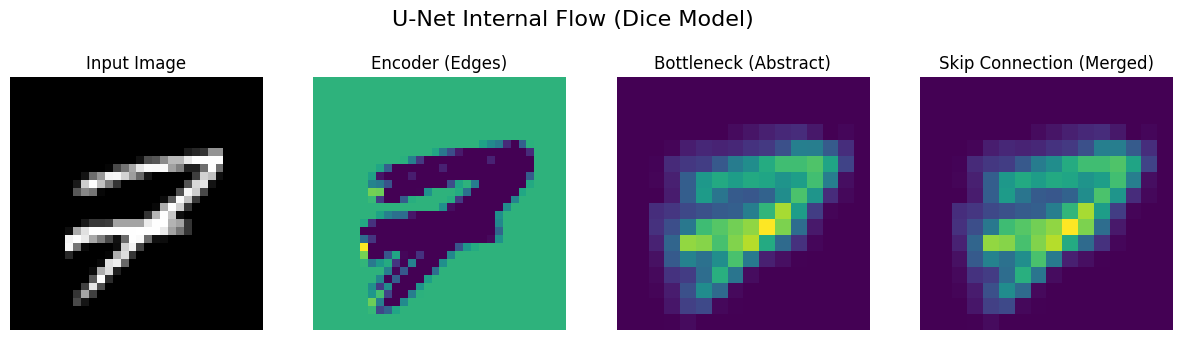

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


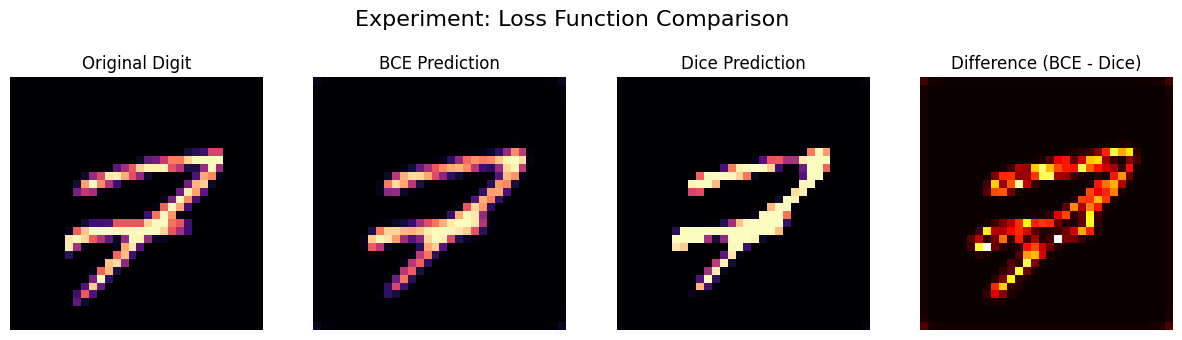

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

def load_and_prep_mnist():
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    # Pad from 28x28 to 32x32 to make U-Net downsampling math clean
    x_train = np.pad(x_train, ((0,0), (2,2), (2,2)), mode='constant') / 255.0
    x_test = np.pad(x_test, ((0,0), (2,2), (2,2)), mode='constant') / 255.0

    x_train = x_train[..., np.newaxis].astype("float32")
    x_test = x_test[..., np.newaxis].astype("float32")

    # For MNIST segmentation, the input image IS the target mask
    return x_train, x_test


def build_unet(input_shape=(32, 32, 1)):
    inputs = layers.Input(input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same', name='enc_1')(inputs)
    p1 = layers.MaxPooling2D(2)(c1) # 16x16

    # Bottleneck
    bn = layers.Conv2D(32, 3, activation='relu', padding='same', name='bottleneck')(p1)

    # Decoder (Upsampling + Skip Connection)
    u1 = layers.UpSampling2D(2)(bn) # 32x32
    concat = layers.Concatenate(name='skip_connection')([u1, c1])
    c2 = layers.Conv2D(16, 3, activation='relu', padding='same', name='dec_1')(concat)

    # Output Layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output')(c2)

    return models.Model(inputs, outputs)


def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# ==========================================
# 4. EXECUTION & TRAINING
# ==========================================
x_train, x_test = load_and_prep_mnist()

# Train model with Binary Cross-Entropy
model_ce = build_unet()
model_ce.compile(optimizer='adam', loss='binary_crossentropy')
print("Training with Cross-Entropy...")
model_ce.fit(x_train[:1000], x_train[:1000], epochs=5, batch_size=32, verbose=0)

# Train model with Dice Loss
model_dice = build_unet()
model_dice.compile(optimizer='adam', loss=dice_loss)
print("Training with Dice Loss...")
model_dice.fit(x_train[:1000], x_train[:1000], epochs=5, batch_size=32, verbose=0)

# ==========================================
# 5. VISUALIZATION SUITE
# ==========================================

def visualize_all(model_ce, model_dice, test_images):
    idx = np.random.randint(0, len(test_images))
    sample = test_images[idx:idx+1]

    # --- Part A: Feature Maps & Skip Connections (Using Dice Model) ---
    vis_layers = ['enc_1', 'bottleneck', 'skip_connection']
    vis_model = models.Model(inputs=model_dice.input,
                             outputs=[model_dice.get_layer(n).output for n in vis_layers])
    features = vis_model.predict(sample)

    plt.figure(figsize=(15, 4))
    plt.suptitle("U-Net Internal Flow (Dice Model)", fontsize=16)

    titles = ['Input Image', 'Encoder (Edges)', 'Bottleneck (Abstract)', 'Skip Connection (Merged)']
    data = [sample[0,:,:,0], features[0][0,:,:,0], features[1][0,:,:,0], features[2][0,:,:,0]]

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(data[i], cmap='viridis' if i > 0 else 'gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

    # --- Part B: Dice vs Cross-Entropy Comparison ---
    pred_ce = model_ce.predict(sample)
    pred_dice = model_dice.predict(sample)

    plt.figure(figsize=(15, 4))
    plt.suptitle("Experiment: Loss Function Comparison", fontsize=16)

    comp_titles = ['Original Digit', 'BCE Prediction', 'Dice Prediction', 'Difference (BCE - Dice)']
    comp_data = [sample[0,:,:,0], pred_ce[0,:,:,0], pred_dice[0,:,:,0], np.abs(pred_ce[0,:,:,0] - pred_dice[0,:,:,0])]

    for i in range(4):
        plt.subplot(1, 4, i+1)
        # Difference map uses 'hot' colormap for clarity
        plt.imshow(comp_data[i], cmap='hot' if i == 3 else 'magma')
        plt.title(comp_titles[i])
        plt.axis('off')
    plt.show()

# Run visuals
visualize_all(model_ce, model_dice, x_test)

Re-training models to capture loss history for visualization...
Binary Cross-Entropy training for visualization complete.
Dice Loss training for visualization complete.


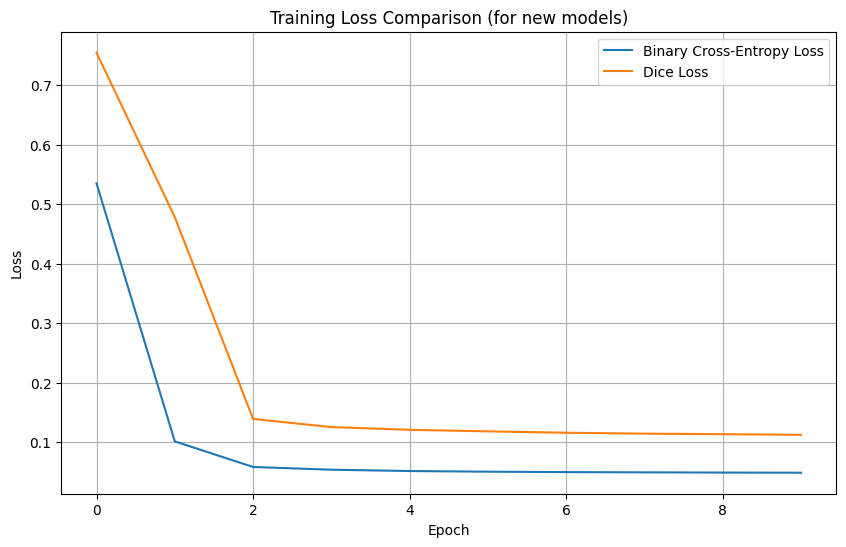

In [2]:
print("Re-training models to capture loss history for visualization...")

# Re-build and re-train models to capture history for loss visualization
# Note: These are new model instances, separate from the ones used in the previous visualization.

# Train model with Binary Cross-Entropy
model_ce_viz = build_unet()
model_ce_viz.compile(optimizer='adam', loss='binary_crossentropy')
history_ce = model_ce_viz.fit(x_train[:1000], x_train[:1000], epochs=10, batch_size=32, verbose=0)
print("Binary Cross-Entropy training for visualization complete.")

# Train model with Dice Loss
model_dice_viz = build_unet()
model_dice_viz.compile(optimizer='adam', loss=dice_loss)
history_dice = model_dice_viz.fit(x_train[:1000], x_train[:1000], epochs=10, batch_size=32, verbose=0)
print("Dice Loss training for visualization complete.")

# Visualize the loss
plt.figure(figsize=(10, 6))
plt.plot(history_ce.history['loss'], label='Binary Cross-Entropy Loss')
plt.plot(history_dice.history['loss'], label='Dice Loss')
plt.title('Training Loss Comparison (for new models)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()